# Classification by ResNet

#### **NOTE：** You can also visit https://www.kaggle.com/code/yanqihong/radar-classification-resent/edit/run/182866222 to run the code directly.

In [1]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from random import randint
import tensorflow_hub as hub

import requests
from PIL import Image
from io import BytesIO

import matplotlib.pyplot as plt
import numpy as np

## Data Processing

In [2]:
import os
class_names=os.listdir('/kaggle/input/radar-data-cfar/image_data_cfar/image_data')
print(class_names)

['stand', 'drink', 'walk', 'sit', 'fall', 'pick']


In [3]:
# Ignore  the warnings
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

# data visualisation and manipulation
import numpy as np
import matplotlib.pyplot as plt
 
import itertools
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model



#model selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,roc_curve,roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder

#preprocess.
from tensorflow.keras.preprocessing.image import ImageDataGenerator



# specifically for cnn
from tensorflow.keras.layers import Dropout, Flatten,Activation
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
 
import tensorflow as tf
import random as rn

# specifically for manipulating zipped images and getting numpy arrays of pixel values of images.
import cv2                  
import numpy as np  
from tqdm import tqdm
import os                   
from random import shuffle  
from zipfile import ZipFile
from PIL import Image

In [4]:
X=[]
Z=[]
IMG_SIZE=256
WALK_DIR='/kaggle/input/radar-data-cfar/image_data_cfar/image_data/walk'
FALL_DIR='/kaggle/input/radar-data-cfar/image_data_cfar/image_data/fall'
DRINK_DIR='/kaggle/input/radar-data-cfar/image_data_cfar/image_data/drink'
PICK_DIR='/kaggle/input/radar-data-cfar/image_data_cfar/image_data/pick'
SIT_DIR='/kaggle/input/radar-data-cfar/image_data_cfar/image_data/sit'
STAND_DIR='/kaggle/input/radar-data-cfar/image_data_cfar/image_data/stand'

In [5]:
def assign_label(img,movement_type):
    return movement_type

In [6]:
def make_train_data(movement_type,DIR):
    for img in tqdm(os.listdir(DIR)):
        label=assign_label(img,movement_type)
        path = os.path.join(DIR,img)
        img = cv2.imread(path,cv2.IMREAD_COLOR)
        img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
        img = np.array(img)
#         img[:, :, 2] = 0
#         img[:, :, 1] = 0
#         img[:, :, 0] = 0
        
        #1: DR 0:RT 2: DT
        
        
        X.append(img)
        Z.append(str(label))

In [7]:
make_train_data('walk',WALK_DIR)
make_train_data('fall',FALL_DIR)
make_train_data('drink',DRINK_DIR)
make_train_data('pick',PICK_DIR)
make_train_data('sit',SIT_DIR)
make_train_data('stand',STAND_DIR)

100%|██████████| 287/287 [00:01<00:00, 161.74it/s]


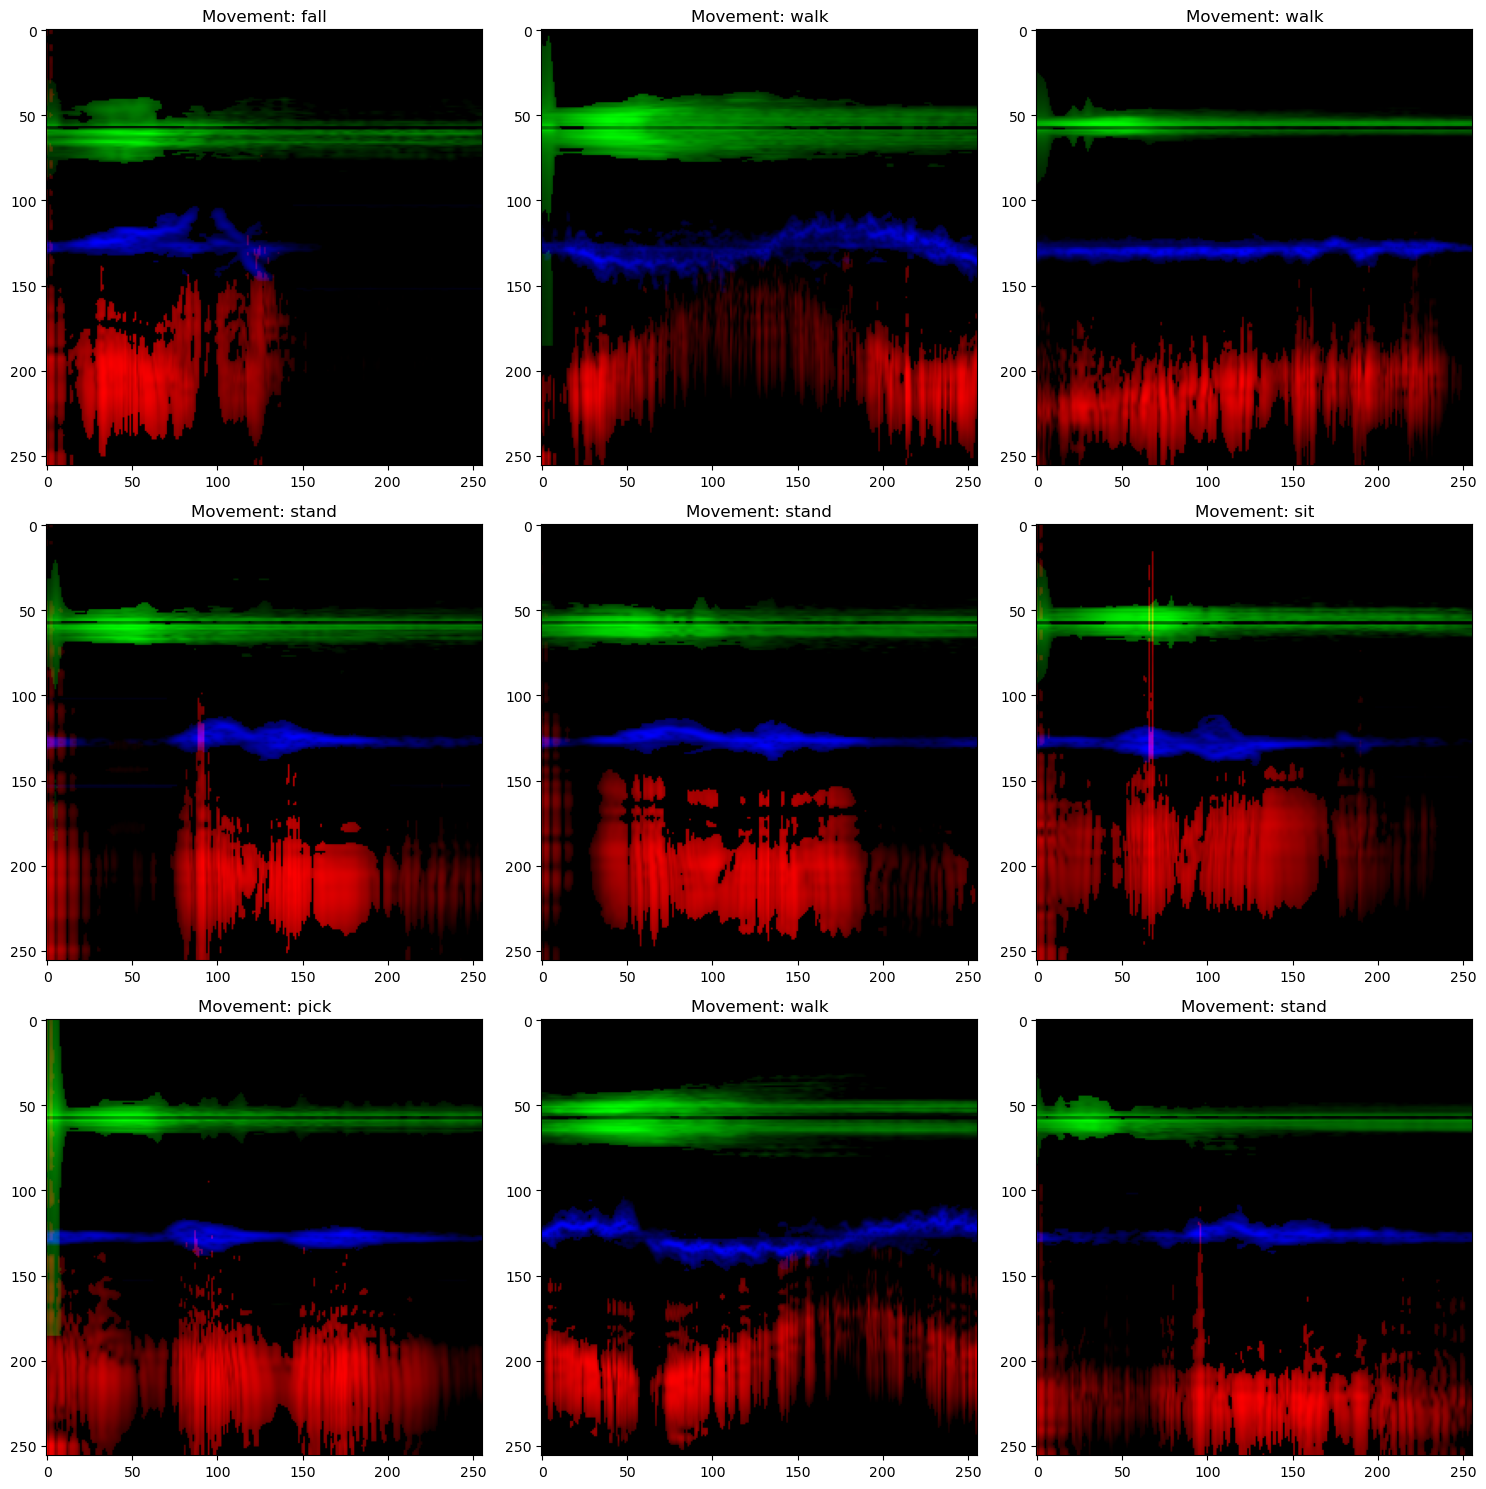

In [8]:
fig,ax=plt.subplots(3,3)
fig.set_size_inches(15,15)
for i in range(3):
    for j in range (3):
        l=rn.randint(0,len(Z))
        ax[i,j].imshow(X[l])
        ax[i,j].set_title('Movement: '+Z[l])
        
plt.tight_layout()

In [9]:
from keras.utils import to_categorical
le=LabelEncoder()
Y=le.fit_transform(Z)
Y=to_categorical(Y,6)
X=np.array(X)
X=X/255

In [10]:
x_data,x_val,y_data,y_val=train_test_split(X,Y,test_size=0.2,random_state=42)
x_train,x_test,y_train,y_test=train_test_split(x_data,y_data,test_size=0.2,random_state=42)

np.random.seed(42)
rn.seed(42)
tf.random.set_seed(42)

## Transfer Learning for ResNet V2

In [11]:
model_name = "resnetv2-152"
model_handle_map = {
  "resnetv2-152": "/kaggle/input/resnet-v2/tensorflow2/152-feature-vector/2",
}

model_image_size_map = {
  "resnetv2-152": 256,
}

model_handle = model_handle_map.get(model_name)
pixels = model_image_size_map.get(model_name, 256)

print(f"Selected model: {model_name} : {model_handle}")

IMAGE_SIZE = (pixels, pixels)
print(f"Input size {IMAGE_SIZE}")

Selected model: resnetv2-152 : /kaggle/input/resnet-v2/tensorflow2/152-feature-vector/2
Input size (256, 256)


In [12]:
num_classes = 6
img_size = (256,256, 3)
do_fine_tuning = False 

print("Building model with", model_handle)
model = tf.keras.Sequential([
    # Explicitly define the input shape so the model can be properly
    # loaded by the TFLiteConverter
    tf.keras.layers.InputLayer(input_shape=IMAGE_SIZE + (3,)),
    hub.KerasLayer(model_handle, trainable=do_fine_tuning),
    tf.keras.layers.Dropout(rate=0.32),
    tf.keras.layers.Dense(6,
                          kernel_regularizer=tf.keras.regularizers.l2(0.001))
])
model.build((None,)+IMAGE_SIZE+(3,))
model.summary()

Building model with /kaggle/input/resnet-v2/tensorflow2/152-feature-vector/2
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 2048)              58331648  
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 6)                 12294     
                                                                 
Total params: 58,343,942
Trainable params: 12,294
Non-trainable params: 58,331,648
_________________________________________________________________


## Compile and Train Model

In [13]:
batch_size=100
epochs=50


datagen = ImageDataGenerator()

datagen.fit(x_train)
from tensorflow.keras.callbacks import LearningRateScheduler
def scheduler(epoch, lr):
     if epoch < 20:
         return lr
     else:
         return lr* np.exp(-0.1) 
callback = LearningRateScheduler(scheduler)
model.compile(
  optimizer='adam', 
  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True, label_smoothing=0.1),
  metrics=['accuracy'])



checkpoint = ModelCheckpoint('model/training_{epoch:02d}.keras',  # Model file name with epoch number
                             save_best_only=True,          # Set to True to save only the best model
                             save_weights_only=False,       # Set to True to save only the weights
                             monitor='val_accuracy',            # Metric to monitor
                             mode='auto',                   # Mode to decide whether to minimize or maximize the monitored metric
                             verbose=1)                     # Verbosity mode

hist = model.fit(datagen.flow(x_train, y_train, batch_size=batch_size),
                              epochs=epochs,
                              validation_data=(x_val, y_val),
                              verbose=1,
                              steps_per_epoch=x_train.shape[0] // batch_size,
                              callbacks=[checkpoint, callback])

Epoch 1/50
10/10 [==============================] - ETA: 0s - loss: 2.0340 - accuracy: 0.2294
Epoch 1: val_accuracy improved from -inf to 0.38415, saving model to model/training_01.keras
10/10 [==============================] - 27s 1s/step - loss: 2.0340 - accuracy: 0.2294 - val_loss: 1.5292 - val_accuracy: 0.3841 - lr: 0.0010
Epoch 2/50
10/10 [==============================] - ETA: 0s - loss: 1.6011 - accuracy: 0.3901
Epoch 2: val_accuracy improved from 0.38415 to 0.53049, saving model to model/training_02.keras
10/10 [==============================] - 7s 692ms/step - loss: 1.6011 - accuracy: 0.3901 - val_loss: 1.3157 - val_accuracy: 0.5305 - lr: 0.0010
Epoch 3/50
10/10 [==============================] - ETA: 0s - loss: 1.3659 - accuracy: 0.5130
Epoch 3: val_accuracy improved from 0.53049 to 0.65854, saving model to model/training_03.keras
10/10 [==============================] - 7s 716ms/step - loss: 1.3659 - accuracy: 0.5130 - val_loss: 1.1789 - val_accuracy: 0.6585 - lr: 0.0010
Epo

## Evaluate

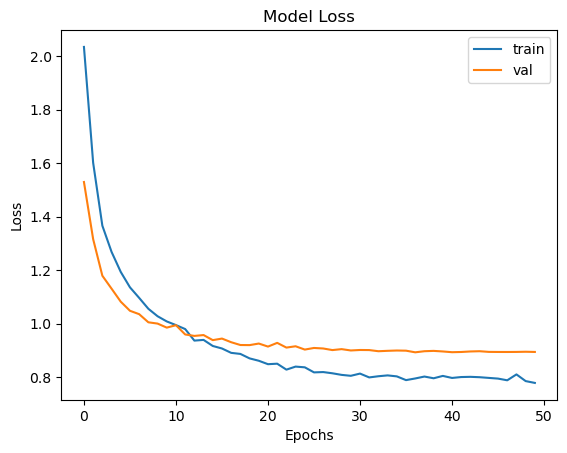

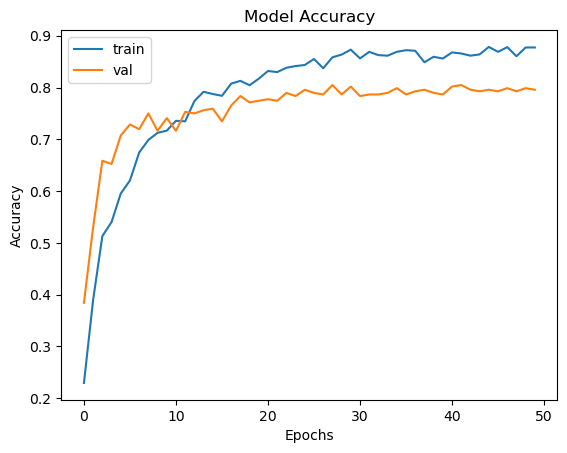

9/9 [==============================] - 2s 165ms/step - loss: 0.8804 - accuracy: 0.8015


[0.880415141582489, 0.8015267252922058]

In [14]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'val'])
plt.show()

plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'val'])
plt.show()

# model = load_model('/home/alexandros/radar/model_epoch_02.keras')
model.evaluate(x_train,y_train)
model.evaluate(x_val,y_val)
model.evaluate(x_test, y_test)

9/9 [==============================] - 3s 151ms/step


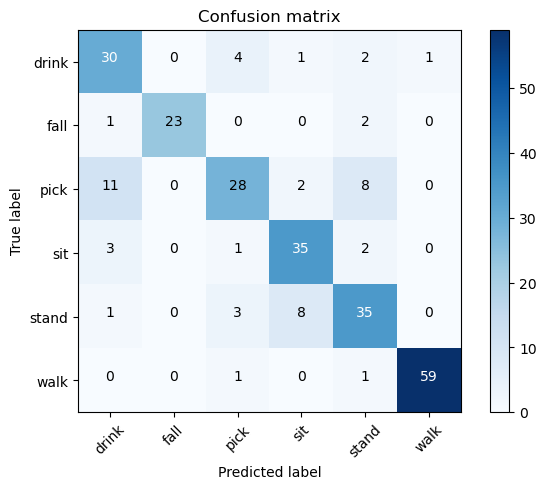

In [15]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
Y_pred = model.predict(x_test)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_test,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
activity=['drink','fall','pick','sit','stand','walk']
plot_confusion_matrix(confusion_mtx, classes = activity ) 